In [2]:
import sys
print(sys.executable)

c:\Users\egriffioen\LLM_Semantics\.venv\Scripts\python.exe


In [3]:
%pip install html2text

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install lxml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
%pip install spacy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
%pip install google

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
from operator import itemgetter

# nltk is what does all the magic language parsing
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

# for parsing wonky HTML-tag-cluttered descriptions
import html2text
from lxml import html

import numpy as np
import re

# for making timing performance tests
import time


# for fetching book descriptions
import requests
from googlesearch import search

# for stop words
from spacy.lang.en import STOP_WORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

# On your first time running this program, you'll need to run the following line to download the stuff from nltk to your local machine
#nltk.download(['stopwords', 'wordnet'])

In [9]:
#Long stop words list using 3 different python stopword libraries

stops = list(set(ENGLISH_STOP_WORDS)) + list(set(stopwords.words('english') +  list(set(STOP_WORDS)) + ["http"]))

In [10]:
#This Block loads the Lexicon and creates a data structure for the emotion intensity

fileEmotion = "emotion_itensity.txt"
table = pd.read_csv(fileEmotion,  names=["word", "emotion", "itensity"], sep='\t')

#create the dictionary with the word/emotion/score
emotion_dic = dict()
lmtzr = WordNetLemmatizer()
for index, row in table.iterrows():
    #add first as it is given in the lexicon
    temp_key = row['word'] + '#' + row['emotion']
    emotion_dic[temp_key] = row['itensity']

    #add in the normal noun form
    temp_key_n = lmtzr.lemmatize(row['word']) + '#' + row['emotion']
    emotion_dic[temp_key_n] = row['itensity']
    
    #add in the normal verb form
    temp_key_v = lmtzr.lemmatize(row['word'], 'v') + '#' + row['emotion']
    emotion_dic[temp_key_v] = row['itensity']    

In [11]:
print(emotion_dic)

{'outraged#anger': 0.964, 'outrage#anger': 0.848, 'brutality#anger': 0.959, 'hatred#anger': 0.953, 'hateful#anger': 0.94, 'terrorize#anger': 0.939, 'infuriated#anger': 0.938, 'infuriate#anger': 0.844, 'violently#anger': 0.938, 'furious#anger': 0.929, 'enraged#anger': 0.927, 'enrage#anger': 0.927, 'furiously#anger': 0.927, 'screwyou#anger': 0.924, 'murderer#anger': 0.922, 'fury#anger': 0.922, 'execution#anger': 0.917, 'angered#anger': 0.916, 'anger#anger': 0.811, 'savagery#anger': 0.915, 'slaughtering#anger': 0.914, 'slaughter#anger': 0.844, 'veryangry#anger': 0.913, 'assassinate#anger': 0.912, 'fuckoff#anger': 0.912, 'annihilation#anger': 0.912, 'rage#anger': 0.911, 'loathe#anger': 0.909, 'damnation#anger': 0.906, 'roadrage#anger': 0.906, 'fucktard#anger': 0.906, 'homicidal#anger': 0.906, 'furor#anger': 0.9, 'hostile#anger': 0.898, 'annihilate#anger': 0.865, 'murder#anger': 0.897, 'raging#anger': 0.896, 'rag#anger': 0.896, 'sopissed#anger': 0.894, 'pissed#anger': 0.894, 'piss#anger': 0

In [12]:
#create h to clean descriptions in case they are in html format
h = html2text.HTML2Text()
h.ignore_links = True

In [13]:
#function that get the emotion itensity
def getEmotionItensity(word,emotion):
    key = word + "#" + emotion
    try:
        return emotion_dic[key]
    except:
        return 0.0

In [14]:
#Check if the word is in the Lexicon
def isWordInEmotionFile(word):
    # Slightly faster implementation
    for key in emotion_dic.keys():
        if key.startswith(word + "#"):
            return True
    return False
    
# print(isWordInEmotionFile("anger"), isWordInEmotionFile("help"), isWordInEmotionFile("booger"))

In [15]:
#Stopping checker 
def isStopWord(word):
    if word in stops:
        return True
    else:
        return False

In [16]:
#Assign the emotion itensity to the dictionary
def calculateEmotion(emotions, word):
    emotions["Anger"] += getEmotionItensity(word, "anger")
    emotions["Anticipation"] += getEmotionItensity(word, "anticipation")
    emotions["Disgust"] += getEmotionItensity(word, "disgust")
    emotions["Fear"] += getEmotionItensity(word, "fear")
    emotions["Joy"] += getEmotionItensity(word, "joy")
    emotions["Sadness"] += getEmotionItensity(word, "sadness")
    emotions["Surprise"] += getEmotionItensity(word, "surprise")
    emotions["Trust"] += getEmotionItensity(word, "trust")

In [17]:
#get the emotion vector of a given text
def getEmotionVector(text, removeObj = False, useSynset = True):
    #create the initial emotions
    emotions = {"Anger": 0.0,
                "Anticipation": 0.0,
                "Disgust": 0.0,
                "Fear": 0.0,
                "Joy": 0.0,
                "Sadness": 0.0,
                "Surprise": 0.0,
                "Trust": 0.0,
                "Objective": 0.0}
    #parse the description
    str = re.sub("[^a-zA-Z]+", " ", text) # replace all non-letters with a space
    pat = re.compile(r'[^a-zA-Z ]+')
    str = re.sub(pat, '', str).lower() #  convert to lowercase

    #split string
    splits = str.split()

    
    #iterate over words array
    for split in splits:
        if not isStopWord(split):
            #first check if the word appears as it does in the text
            if isWordInEmotionFile(split): 
                calculateEmotion(emotions, split)
                
            # check the word in noun form (bats -> bat)
            elif isWordInEmotionFile(lmtzr.lemmatize(split)):
                calculateEmotion(emotions, lmtzr.lemmatize(split))
                
            # check the word in verb form (ran/running -> run)
            elif isWordInEmotionFile(lmtzr.lemmatize(split, 'v')):
                calculateEmotion(emotions, lmtzr.lemmatize(split, 'v'))  
                
            # check synonyms of this word
            elif useSynset and wordnet.synsets(split) is not None:
                # only check the first two "senses" of a word, so we don't stray too far from its intended meaning
                # for syn in wordnet.synsets(split)[0:1]:
                #     for l in syn.lemmas():
                #         if isWordInEmotionFile(l.name()):
                #             calculateEmotion(emotions, l.name())
                #             continue
                            
                # # none of the synonyms matched something in the file
                # emotions["Objective"] += 1
                found_syn = False
                for syn in wordnet.synsets(split)[0:1]:
                    for l in syn.lemmas():
                        if isWordInEmotionFile(l.name()):
                            calculateEmotion(emotions, l.name())
                            found_syn = True
                            break
                    if found_syn:
                        break

                if not found_syn:
                    emotions["Objective"] += 1
                
            else:
                # not found in the emotion file, assign a score to Objective instead
                emotions["Objective"] += 1

    # remove the Objective category if requested
    if removeObj:
        del emotions['Objective']
        
    total = sum(emotions.values())
    for key in sorted(emotions.keys()):
        try:
            # normalize the emotion vector
            emotions[key] = (1.0 / total) * emotions[key]
        except:
            emotions[key] = 0

    return emotions


In [18]:
# Fetch a book's description from Apple Books given its name
def fetchBookDesc(name):
    # find the url via google
    query = "site:books.apple.com " + name
    returnSearch = search(query, tld='com', lang='en', num=1, stop=3, pause=0.5)
    #returnSearch = search(query, lang='en', num=1, stop=3, pause=0.5)
    url = next(returnSearch)
    
    # need to pretend to be a user rather than a robot
    headers = {    'User-Agent': 'My User Agent 1.0',}
    page = requests.get(url, headers=headers)
    page.raise_for_status()

    # by knowing how apple books is laid out, we can find the div with the description
    tree = html.fromstring(page.content)
    frame = tree.xpath('//div[not(@class="we-lockup__title ")]/p[not(contains(text(),"\n"))]/text()')
    
    # convert frame to a string description
    return ' '.join(frame)
    
# fetchBookDesc("Harry Potter and the Chamber of Secrets")

In [18]:
fetchBookDesc("Harry Potter")

StopIteration: 

In [19]:
fetchBookDesc("Shadow and Bone")

StopIteration: 

In [20]:
#This block just test the functions above
#open description file
# fetch book description from Apple Books
str_f = fetchBookDesc("Shadow and Bone")
formatedDescription = h.handle(str_f)
results = getEmotionVector(formatedDescription)

print(results)

StopIteration: 

In [ ]:
# #This block just test the functions above
# #open description file
# file = open("description.txt","r")
# str_f = file.read()
# file.close()

# # fetch book description from Apple Books
# str_f = fetchBookDesc("Stephen King's IT: novel")
# formatedDescription = h.handle(str_f)
# results = getEmotionVector(formatedDescription)

# print(results)

{'Anger': 0.04683065279091769, 'Anticipation': 0.07732908430015435, 'Disgust': 0.04350694617338047, 'Fear': 0.10149131105910471, 'Joy': 0.07150326146492059, 'Sadness': 0.0734949957675646, 'Surprise': 0.03763132998058059, 'Trust': 0.06272718219389534, 'Objective': 0.4854852362694816}


In [21]:
#This block just test the functions above
#open description file
# file = open("description.txt","r")
# str_f = file.read()
# file.close()

# fetch book description from Apple Books
# str_f = fetchBookDesc("Stephen King's IT: novel")
# formatedDescription = h.handle(str_f)
# results = getEmotionVector(formatedDescription)

# print(results)

import matplotlib.pyplot as plt
from pylab import rcParams

# Graphs the emotion vector as a horizontal bar graph
def graphVector(results, title="Emotion Intensity", hasObjective = True):
    r = dict(results)
    if hasObjective:
        plt.barh(range(len(r)), list(r.values()), align='center')
        plt.yticks(range(len(r)), list(r.keys()))
    
        #plt.xlabel('Emotion')
        plt.title(title + ' with Objective')
        plt.show()
        
        del r['Objective']
        
    plt.barh(range(len(r)), list(r.values()), align='center')
    plt.yticks(range(len(r)), list(r.keys()))

    #plt.xlabel('Emotion')
    plt.title(title)
    plt.show()

# graphVector(results)

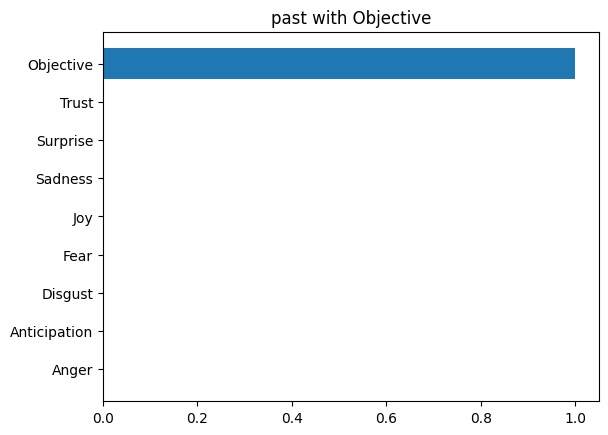

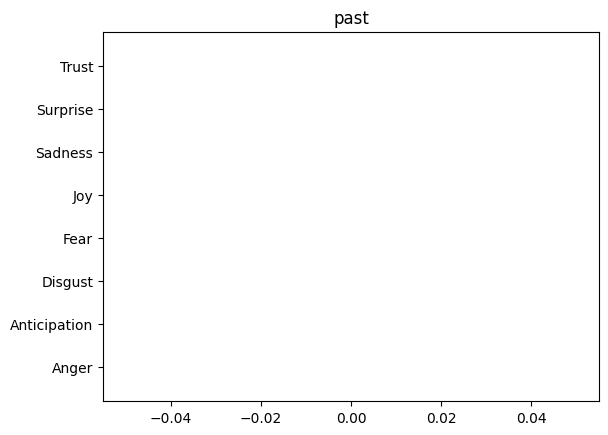

In [22]:
word = "past"
graphVector(getEmotionVector(word), word)

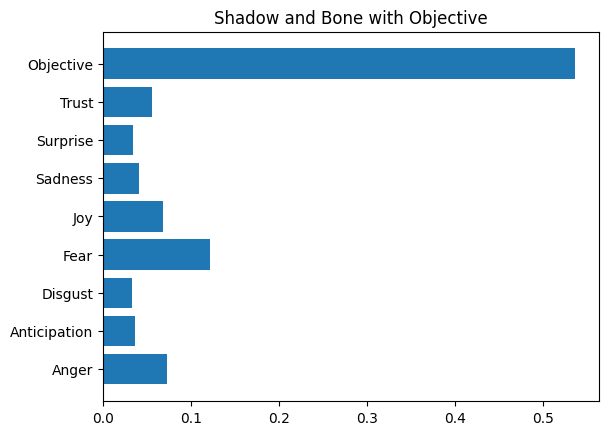

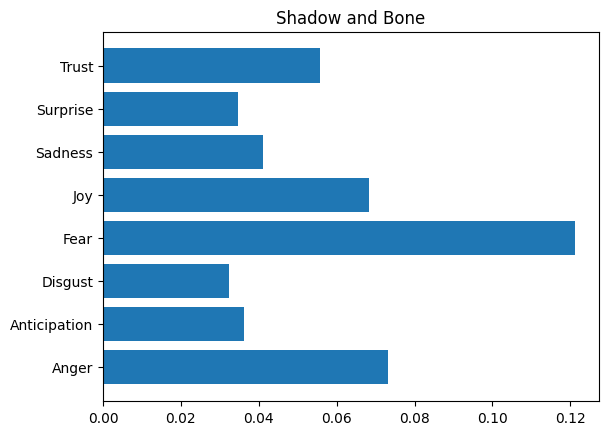

In [120]:
graphVector(results, "Shadow and Bone")

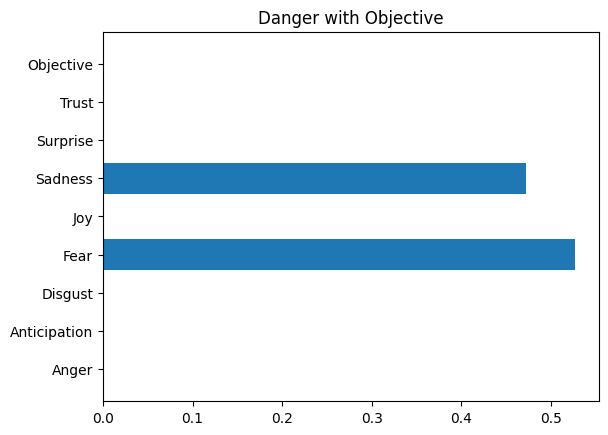

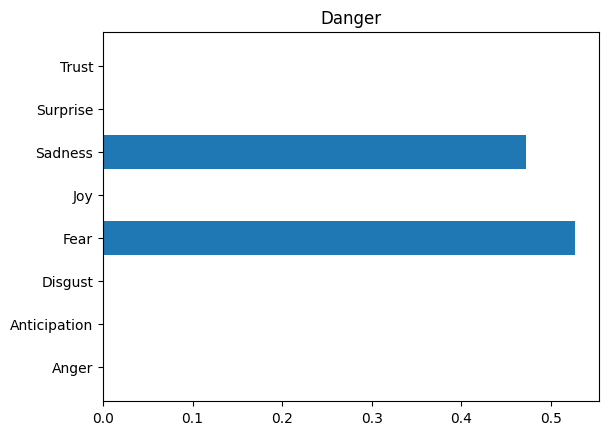

In [121]:
graphVector(getEmotionVector("danger"), "Danger")

In [122]:
#This block run over all the books on the CSV file
#before executing this cell, make sure the csv file has a column called "emotion_NRC_objective"

# THIS WILL TAKE A WHILE
csv_file = 'complete_pl.csv'
books = pd.read_csv(csv_file)
for index, row in books.iterrows():
    description = h.handle(row['description'])
    books.loc[index, 'emotion_NRC_objective'] = str(getEmotionVector(description))
#output file    
books.to_csv('complete_pl_output_test.csv')

C:\Users\egriffioen\AppData\Local\Temp\ipykernel_10584\2292644732.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{'Anger': 0.01971583050421225, 'Anticipation': 0.17580787124355587, 'Disgust': 0.014133031560417453, 'Fear': 0.04073934364390796, 'Joy': 0.12246950836162454, 'Sadness': 0.00314346787375833, 'Surprise': 0.05167861184458695, 'Trust': 0.1196529611467371, 'Objective': 0.45265937382119953}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  books.loc[index, 'emotion_NRC_objective'] = str(getEmotionVector(description))


In [68]:
# Generate a vector for every book in the csv file, then output those vectors to another file
# Only needs to be run once per file
# THIS WILL TAKE A WHILE
ratings_file = '../Data/Teenager_GoodReads.csv'
books = pd.read_csv(ratings_file)
# initialize the columns in the dataframe where our emotion vectors go
books["no_synset"] = "" * len(books.index)
books["synset"] = "" * len(books.index)

# add all the vectors to a csv file
sampleSize = 2000
startIndex = 3020

for index in range(startIndex, startIndex + sampleSize):
   
    d = books.loc[index, 'description']
    if d is None or type(d) is not str:
        continue
        
    description = h.handle(d)
#     print(index, description)
    
    books.loc[index, 'no_synset'] = str(getEmotionVector(description, useSynset = False))
    books.loc[index, 'synset'] = str(getEmotionVector(description))
#output file    
books.to_csv('ratings_teen_processed_test.csv')

KeyboardInterrupt: 

In [69]:
import math
# THIS WILL TAKE A WHILE
# TEENAGERS
# run over all ratings and get the ones with these params's averaged emotional vector
# ratings_file = '../../../Data/.csv'


# print(ratings)

avgVector = getEmotionVector("")
for index, row in ratings.iterrows():
#     print(row["title"])
    if math.floor(row["age"]) in range(18,20): # edit this for age
        r = row["avg_rating"]
        if r is None or type(r) not in [int, float] or math.isnan(r):
            continue
            
        if math.floor(r) in range(0, 5): # edit this for ratings 
            # make sure the discription exists, otherwise we discount it
            d = row["description"]
            if d is None or type(d) is not str:
                continue
#                 print(d)
            # description exists
            description = h.handle(d)
            v = getEmotionVector(description)
            for key in avgVector:
                avgVector[key] += v[key]

graphVector(avgVector)

KeyboardInterrupt: 

In [23]:
def graphDictionary(dict, desc = ""):
    graphVector(dict["12-13"], "12-13" + desc)
    graphVector(dict["14-15"], "14-15" + desc)
    graphVector(dict["16-17"], "16-17" + desc)
    graphVector(dict["18+"], "18-19" + desc)

In [24]:
import math

ratings_file = '../Data/Teenager_GoodReads.csv' # teenager review data
ratings = pd.read_csv(ratings_file)

rat_12 = ratings[ratings["age"] == 12]

ageRatings = {
    12: [],
    13: [],
    14: [],
    15: [],
    16: [],
    17: [],
    18: [],
    19: []
}
for age in range(12, 20):
    ageRatings[age] = ratings[(ratings["age"] >= age) & (ratings['age'] < age+1)]

# ageRatings[14].head()

In [25]:
ageRatings[12].head()
# ageRatings[13].head()
# ageRatings[14].head()
# ageRatings[15].head()
# ageRatings[16].head()
# ageRatings[17].head()
# ageRatings[18].head()
# ageRatings[19].head()

,Unnamed: 0,ISBN,ID,title,authors,description,avg_rating,age
135,135,9780446518581,778703,Border Music,[Robert James Waller],Most people don't run out the back door of a p...,3.30,12.0
487,487,9780140346039,2785252,"Knights of the Kitchen Table (Time Warp Trio, #1)","[Jon Scieszka, Lane Smith]",The first four books of the wildly popular Tim...,3.68,12.0
488,488,9780140346848,1111978,"The Not-So-Jolly Roger (Time Warp Trio, #2)","[Jon Scieszka, Lane Smith, Adam McCauley]",The first four books of the wildly popular Tim...,3.76,12.0
489,489,9780613286626,2762163,Summer Reading Is Killing Me!,"[Jon Scieszka, Lane Smith]","Joe, Fred, and Sam have no idea why they",3.83,12.0
491,491,9780671024406,221269,"Caliban Cove (Resident Evil, #2)",[S.D. Perry],In the aftermath of their ordeal through the U...,3.64,12.0


In [26]:
# create the graph representing the books rated between min and max rating, considering specified ages (list)
def makeGraphs(ages, minRating=0, maxRating=5):
    print(ages,minRating,maxRating)
    avgVector = getEmotionVector("")

    for age in ages:
        print("Parsing data for ", age, " year-olds")
        data = ageRatings[age]
        filtered = data[(data["avg_rating"] >= minRating) & (data["avg_rating"] <= maxRating)]
        
        limit = 100 # only select a sample of this many
        currIter = 0
        for index, row in filtered.iterrows():
            if currIter >= limit:
                break
            currIter += 1

            
            d = row["description"]
            if d is None or type(d) is not str:
                continue

            # description exists
            description = h.handle(d)
            v = getEmotionVector(description)
            for key in avgVector:
                avgVector[key] += v[key]
    
    return avgVector

In [27]:
def noObj(v):
    r = dict(v)
    del r["Objective"]
    return r

In [28]:
def graphDifference(a, b, title = "difference"):
    # graph the difference between two emotion vectors
    dif = b - a
    emotions = {"Anger": dif[0],
            "Anticipation": dif[1],
            "Disgust": dif[2],
            "Fear": dif[3],
            "Joy": dif[4],
            "Sadness": dif[5],
            "Surprise": dif[6],
            "Trust": dif[7]}
    if len(dif) > 8:
        emotions["Objective"] = dif[8]
    # visually show the difference
    graphVector(emotions, title, False)
    return dif

In [29]:
def vectorMatch(zero, compare, shouldGraph = True, title = "difference"):
    # compare how close 'zero' and 'compare' are to each other visually
#     graphVector(zero, 'samp', False)
#     graphVector(compare, 'comp', False)
    # convert to np arrays
    zero = np.array(list(zero.values()))
    compare = np.array(list(compare.values()))
    
    # normalize both vectors
    zero = zero / np.linalg.norm(zero)
    compare = compare / np.linalg.norm(compare)
    
    # graph the difference graph
    if shouldGraph:
        graphDifference(zero, compare, title)
    
    # return the magnitude of the vector of the difference
    return np.linalg.norm(compare - zero)

# experiment shows that objective should largely be ignored


In [ ]:
# DICTIONARY STRINGS
# See Also: Appendix II of our paper, located at the root of this github repo

# without synset
veryGood = {'12-13': {'Anger': 0.02607737447252457, 'Anticipation': 0.05591565890156308, 'Disgust': 0.016045564608362352, 'Fear': 0.04789091036691487, 'Joy': 0.07800394549107047, 'Sadness': 0.02963231050132504, 'Surprise': 0.025570341420305114, 'Trust': 0.07646456858162831, 'Objective': 0.6443993256563062}, '14-15': {'Anger': 0.03133700242969171, 'Anticipation': 0.05306542575331012, 'Disgust': 0.02052466230415404, 'Fear': 0.050078575418488806, 'Joy': 0.07091271631929497, 'Sadness': 0.036037637580607344, 'Surprise': 0.024350939438084956, 'Trust': 0.07197318113344676, 'Objective': 0.6417198596229213}, '16-17': {'Anger': 0.0333773979974969, 'Anticipation': 0.05330467754243581, 'Disgust': 0.02097467965804083, 'Fear': 0.05641121602721728, 'Joy': 0.0717972294372776, 'Sadness': 0.04119477515402107, 'Surprise': 0.02393239572109254, 'Trust': 0.07262647668304764, 'Objective': 0.6263811517793704}, '18+': {'Anger': 0.027350619283685446, 'Anticipation': 0.04834423625870798, 'Disgust': 0.01810802229683925, 'Fear': 0.04711267423376138, 'Joy': 0.0682425285607569, 'Sadness': 0.03469139079167855, 'Surprise': 0.024225540160949112, 'Trust': 0.07372016783601339, 'Objective': 0.658204820577608}}
medium = {'12-13': {'Anger': 0.029189140945891232, 'Anticipation': 0.051557508020711164, 'Disgust': 0.016899369038538357, 'Fear': 0.04755995823626276, 'Joy': 0.06660662293889227, 'Sadness': 0.03507920186496511, 'Surprise': 0.028374183831625363, 'Trust': 0.07083812291298776, 'Objective': 0.6538958922101261}, '14-15': {'Anger': 0.0285833109659729, 'Anticipation': 0.057618467957265156, 'Disgust': 0.01961486079752071, 'Fear': 0.052700259717779016, 'Joy': 0.07232740308860498, 'Sadness': 0.03513043731590352, 'Surprise': 0.02588909747908478, 'Trust': 0.07539679181497354, 'Objective': 0.6327393708628954}, '16-17': {'Anger': 0.025644625944838434, 'Anticipation': 0.051360156037244954, 'Disgust': 0.017925369540969096, 'Fear': 0.04640777241724535, 'Joy': 0.060824867086734236, 'Sadness': 0.03225630922943315, 'Surprise': 0.026661435749587997, 'Trust': 0.06426302689204114, 'Objective': 0.6746564371019056}, '18+': {'Anger': 0.02526227585581172, 'Anticipation': 0.04694168121197902, 'Disgust': 0.018564253736720836, 'Fear': 0.04646442057241248, 'Joy': 0.0634355612618883, 'Sadness': 0.03280124674603629, 'Surprise': 0.024291726419989793, 'Trust': 0.07112877986963899, 'Objective': 0.6711100543255224}}
bad = {'12-13': {'Anger': 0.014256266830366897, 'Anticipation': 0.049176530976752016, 'Disgust': 0.007874240160354389, 'Fear': 0.025594917066862136, 'Joy': 0.06747528283150003, 'Sadness': 0.016159672424431983, 'Surprise': 0.02917186766565966, 'Trust': 0.07731285216349064, 'Objective': 0.7129783698805822}, '14-15': {'Anger': 0.014115226149470509, 'Anticipation': 0.04034092911328387, 'Disgust': 0.010038021527596707, 'Fear': 0.029141883181940137, 'Joy': 0.058447614793800576, 'Sadness': 0.01528371769742746, 'Surprise': 0.014531136480208482, 'Trust': 0.09533626642161397, 'Objective': 0.7227652046346582}, '16-17': {'Anger': 0.018530938051548828, 'Anticipation': 0.04952214921103868, 'Disgust': 0.010244400746641341, 'Fear': 0.03049261738092707, 'Joy': 0.06100403145970391, 'Sadness': 0.023510096408279352, 'Surprise': 0.017283416843489417, 'Trust': 0.0778980982594321, 'Objective': 0.7115142516389393}, '18+': {'Anger': 0.018685170909377744, 'Anticipation': 0.04940155601721161, 'Disgust': 0.016405495432130657, 'Fear': 0.035722493931139354, 'Joy': 0.06305838192496861, 'Sadness': 0.022540359501121345, 'Surprise': 0.016742206897730393, 'Trust': 0.07503267563743672, 'Objective': 0.7024116597488834}}

# with synset
# veryGood = {'12-13': {'Anger': 0.03324516731797181, 'Anticipation': 0.06316521380213953, 'Disgust': 0.022227091137027172, 'Fear': 0.05691485227312035, 'Joy': 0.08137360321373614, 'Sadness': 0.03561005495603787, 'Surprise': 0.02753410719569374, 'Trust': 0.08740544859699105, 'Objective': 0.5925244615072824}, '14-15': {'Anger': 0.03845659187984517, 'Anticipation': 0.05968186928716008, 'Disgust': 0.024811851649648775, 'Fear': 0.060174546666221615, 'Joy': 0.07738135360361288, 'Sadness': 0.041013853384338446, 'Surprise': 0.026242366975899992, 'Trust': 0.08078540253353338, 'Objective': 0.5914521640197395}, '16-17': {'Anger': 0.03937934022078974, 'Anticipation': 0.06168553740119403, 'Disgust': 0.02437694812017651, 'Fear': 0.06467916627690419, 'Joy': 0.07596938986336625, 'Sadness': 0.04700959580673139, 'Surprise': 0.02631626776151658, 'Trust': 0.08092024537924439, 'Objective': 0.579663509170077}, '18+': {'Anger': 0.032588571818511436, 'Anticipation': 0.056495245508095024, 'Disgust': 0.021237897122595596, 'Fear': 0.054496669724892546, 'Joy': 0.07277402651940436, 'Sadness': 0.039143449052118896, 'Surprise': 0.025819972212946407, 'Trust': 0.08610576994731546, 'Objective': 0.6113383980941202}} 
# medium = {'12-13': {'Anger': 0.03374098128626937, 'Anticipation': 0.06018846633940684, 'Disgust': 0.019014375576554318, 'Fear': 0.054401185770716745, 'Joy': 0.07337335029206232, 'Sadness': 0.04040692892957006, 'Surprise': 0.030654045663137744, 'Trust': 0.08191808222017224, 'Objective': 0.6063025839221104}, '14-15': {'Anger': 0.03359076268594646, 'Anticipation': 0.06787135639254616, 'Disgust': 0.023418184759612503, 'Fear': 0.06048732307267755, 'Joy': 0.07937567941882766, 'Sadness': 0.04013902205286797, 'Surprise': 0.02947897436360671, 'Trust': 0.08800879300797261, 'Objective': 0.5776299042459424}, '16-17': {'Anger': 0.030456968279124176, 'Anticipation': 0.059058054919972264, 'Disgust': 0.02198290389875575, 'Fear': 0.05303760271253788, 'Joy': 0.0657024268770311, 'Sadness': 0.036185701108150475, 'Surprise': 0.029020076627564884, 'Trust': 0.0760225808088485, 'Objective': 0.628533684768015}, '18+': {'Anger': 0.031729533860877006, 'Anticipation': 0.05606660712348232, 'Disgust': 0.022249649499262326, 'Fear': 0.05366896026485633, 'Joy': 0.06871372152832912, 'Sadness': 0.036852106253912366, 'Surprise': 0.025940952655220298, 'Trust': 0.08186879744428478, 'Objective': 0.6229096713697754}} 
# bad = {'12-13': {'Anger': 0.017655532155044198, 'Anticipation': 0.05744157750390466, 'Disgust': 0.008167936076363206, 'Fear': 0.030417773390982866, 'Joy': 0.07423649832532445, 'Sadness': 0.017440343259113648, 'Surprise': 0.02993467844844481, 'Trust': 0.08817932713834818, 'Objective': 0.676526333702474}, '14-15': {'Anger': 0.02020149395761844, 'Anticipation': 0.047565525231736176, 'Disgust': 0.014517292449512638, 'Fear': 0.03547664051539909, 'Joy': 0.06533833356520834, 'Sadness': 0.021882118715121295, 'Surprise': 0.017664024997972833, 'Trust': 0.1132199386684898, 'Objective': 0.6641346318989414}, '16-17': {'Anger': 0.023330231392691952, 'Anticipation': 0.05884361939206312, 'Disgust': 0.014104841767633436, 'Fear': 0.037962854154754415, 'Joy': 0.06730466563882047, 'Sadness': 0.02811541783833771, 'Surprise': 0.018701038338162976, 'Trust': 0.0913024999787434, 'Objective': 0.6603348314987926}, '18+': {'Anger': 0.02356251104255825, 'Anticipation': 0.05656267181417433, 'Disgust': 0.019254852068808205, 'Fear': 0.042011270869920375, 'Joy': 0.07456356532678587, 'Sadness': 0.0259438858942028, 'Surprise': 0.018840096630702702, 'Trust': 0.08805987687649008, 'Objective': 0.6512012694763574}}



In [130]:
# THIS WILL TAKE A WHILE

# initialize dicts for rating ranges, defined below
veryGood = {
    "12-13": {},
    "14-15":{},
    "16-17":{},
    "18+":{}
}
medium = {
    "12-13": {},
    "14-15":{},
    "16-17":{},
    "18+":{}
}
bad = {
    "12-13": {},
    "14-15":{},
    "16-17":{},
    "18+":{}
}


# Very Good: 4-5
# Medium: 2.5-4
# Bad: 0-2.5

minRating = 4
print("Very Good")
# print("Sampling 12-13")
veryGood["12-13"] = makeGraphs([12,13], minRating)
# print("Sampling 14-15")
veryGood["14-15"] = makeGraphs([14,15], minRating)
# print("Sampling 16-17")
veryGood["16-17"] = makeGraphs([16,17], minRating)
# print("Sampling 18+")
veryGood["18+"] = makeGraphs([18,19], minRating)

print("Medium")
minRating = 2.5
maxRating = 4
# print("Sampling 12-13")
medium["12-13"] = makeGraphs([12,13], minRating, maxRating)
# print("Sampling 14-15")
medium["14-15"] = makeGraphs([14,15], minRating, maxRating)
# print("Sampling 16-17")
medium["16-17"] = makeGraphs([16,17], minRating, maxRating)
# print("Sampling 18+")
medium["18+"] = makeGraphs([18,19], minRating, maxRating)

print("Bad")
minRating = 0
maxRating = 2.5
# print("Sampling 12-13")
bad["12-13"] = makeGraphs([12,13], minRating, maxRating)
# print("Sampling 14-15")
bad["14-15"] = makeGraphs([14,15], minRating, maxRating)
# print("Sampling 16-17")
bad["16-17"] = makeGraphs([16,17], minRating, maxRating)
# print("Sampling 18+")
bad["18+"] = makeGraphs([18,19], minRating, maxRating)

Very Good
[12, 13] 4 5
Parsing data for  12  year-olds
Parsing data for  13  year-olds
[14, 15] 4 5
Parsing data for  14  year-olds
Parsing data for  15  year-olds
[16, 17] 4 5
Parsing data for  16  year-olds
Parsing data for  17  year-olds
[18, 19] 4 5
Parsing data for  18  year-olds
Parsing data for  19  year-olds
Medium
[12, 13] 2.5 4
Parsing data for  12  year-olds
Parsing data for  13  year-olds
[14, 15] 2.5 4
Parsing data for  14  year-olds
Parsing data for  15  year-olds
[16, 17] 2.5 4
Parsing data for  16  year-olds
Parsing data for  17  year-olds
[18, 19] 2.5 4
Parsing data for  18  year-olds
Parsing data for  19  year-olds
Bad
[12, 13] 0 2.5
Parsing data for  12  year-olds
Parsing data for  13  year-olds
[14, 15] 0 2.5
Parsing data for  14  year-olds
Parsing data for  15  year-olds
[16, 17] 0 2.5
Parsing data for  16  year-olds
Parsing data for  17  year-olds
[18, 19] 0 2.5
Parsing data for  18  year-olds
Parsing data for  19  year-olds


In [30]:
def cosine_similarity(vec1, vec2):
    v1 = np.array(list(vec1.values()), dtype = float)
    v2 = np.array(list(vec2.values()), dtype = float)
    if np.linalg.norm(v1) == 0 or np.linalg.norm(v2) == 0:
        return 0.0
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [ ]:
# description = "Emily Starr was born with the desire to write. As an orphan living on New Moon Farm, writing helped her face the difficult, lonely times. But now all her friends are going away to high school in nearby Shrewsbury, and her old-fashioned, tyrannical aunt Elizabeth will only let <i>her</i> go if she promises to stop writing! All the same, this is the first step in Emily's climb to success. Once in town, Emily's activities set the Shrewsbury gossips buzzing. But Emily and her friends are confident -- Ilse's a born actress, Teddy's set to be a great artist, and roguish Perry has the makings of a brilliant lawyer. When Emily has her poems published and writes for the town newspaper, success seems to be on its way -- and with it the first whispers of romance. Then Emily is offered a fabulous opportunity, and she must decide if she wants to change her life forever."
# description = "Just after midnight, a snowdrift stops the Orient Express in its tracks. The luxurious train is surprisingly full for the time of the year, but by the morning it is one passenger fewer. An American tycoon lies dead in his compartment, stabbed a dozen times, his door locked from the inside.<br /><br />Isolated and with a killer in their midst, detective Hercule Poirot must identify the murderer—in case he or she decides to strike again."
# description = "Dana, a modern black woman, is celebrating her twenty-sixth birthday with her new husband when she is snatched abruptly from her home in California and transported to the antebellum South. <br />Rufus, the white son of a plantation owner, is drowning, and Dana has been summoned across the years to save him. After this first summons, Dana is drawn back, again and again, to the plantation to protect Rufus and ensure that he will grow to manhood and father the daughter who will become Dana's ancestor. <br />Yet each time Dana's sojourns become longer and more dangerous, until it is uncertain whether or not her life will end, long before it has even begun."

# description = "Ramsay is a man twice born, a man who has returned from the hell of the battle-grave at Passchendaele in World War I decorated with the Victoria Cross and destined to be caught in a no man's land where memory, history, and myth collide. As Ramsay tells his story, it begins to seem that from boyhood, he has exerted a perhaps mystical, perhaps pernicious, influence on those around him. His apparently innocent involvement in such innocuous events as the throwing of a snowball or the teaching of card tricks to a small boy in the end prove neither innocent nor innocuous. Fifth Business stands alone as a remarkable story told by a rational man who discovers that the marvelous is only another aspect of the real."

# bookvec = getEmotionVector(description)
# print(bookvec)
# print(cosine_similarity(veryGood['12-13'], bookvec))
# print(cosine_similarity(veryGood['14-15'], bookvec))
# print(cosine_similarity(veryGood['16-17'], bookvec))
# print(cosine_similarity(veryGood['18+'], bookvec))

{'Anger': 0.06674602046617395, 'Anticipation': 0.020128624218305854, 'Disgust': 0.014159323479249572, 'Fear': 0.10691444002274017, 'Joy': 0.042122654917566796, 'Sadness': 0.06388573052870948, 'Surprise': 0.04343732234223991, 'Trust': 0.10963260375213188, 'Objective': 0.5329732802728823}
0.9861186926895676
0.9881906150656943
0.9890713406439405
0.9873140972864556


In [31]:
#description = ""
bookvec = getEmotionVector(description, True)
agevec12 = noObj(veryGood['12-13'])
agevec14 = noObj(veryGood['14-15'])
agevec16 = noObj(veryGood['16-17'])
agevec18 = noObj(veryGood['18+'])
print(cosine_similarity(agevec12, bookvec))
print(cosine_similarity(agevec14, bookvec))
print(cosine_similarity(agevec16, bookvec))
print(cosine_similarity(agevec18, bookvec))

NameError: name 'description' is not defined

In [133]:
print(agevec12)
print(agevec14)
print(agevec16)
print(agevec18)

{'Anger': 5.927893858558608, 'Anticipation': 11.774090900022692, 'Disgust': 3.7099381487640377, 'Fear': 10.411844614735664, 'Joy': 15.147968816116212, 'Sadness': 6.428811674741225, 'Surprise': 5.140083150800002, 'Trust': 16.25898878232859}
{'Anger': 6.907142974948354, 'Anticipation': 10.844176180407933, 'Disgust': 4.490635113638092, 'Fear': 11.033458484551485, 'Joy': 14.164284747029246, 'Sadness': 7.528025345850492, 'Surprise': 4.784126354368735, 'Trust': 15.062223909500636}
{'Anger': 7.961412135254432, 'Anticipation': 12.757786798148715, 'Disgust': 4.933842249367233, 'Fear': 13.351913875201173, 'Joy': 15.92586857607219, 'Sadness': 9.763983244477446, 'Surprise': 5.474288048302499, 'Trust': 16.686459400627697}
{'Anger': 6.048835330136506, 'Anticipation': 10.697052340264571, 'Disgust': 3.9251773561547, 'Fear': 10.116238960353723, 'Joy': 14.021273486371621, 'Sadness': 7.400276790008229, 'Surprise': 4.87107530912405, 'Trust': 16.471331287592164}


In [37]:
print(veryGood)
print(medium)
print(bad)

{'12-13': {'Anger': 5.927893858558608, 'Anticipation': 11.774090900022692, 'Disgust': 3.7099381487640377, 'Fear': 10.411844614735664, 'Joy': 15.147968816116212, 'Sadness': 6.428811674741225, 'Surprise': 5.140083150800002, 'Trust': 16.25898878232859, 'Objective': 98.20038005393303}, '14-15': {'Anger': 6.907142974948354, 'Anticipation': 10.844176180407933, 'Disgust': 4.490635113638092, 'Fear': 11.033458484551485, 'Joy': 14.164284747029246, 'Sadness': 7.528025345850492, 'Surprise': 4.784126354368735, 'Trust': 15.062223909500636, 'Objective': 99.18592688970504}, '16-17': {'Anger': 7.961412135254432, 'Anticipation': 12.757786798148715, 'Disgust': 4.933842249367233, 'Fear': 13.351913875201173, 'Joy': 15.92586857607219, 'Sadness': 9.763983244477446, 'Surprise': 5.474288048302499, 'Trust': 16.686459400627697, 'Objective': 108.14444567254868}, '18+': {'Anger': 6.048835330136506, 'Anticipation': 10.697052340264571, 'Disgust': 3.9251773561547, 'Fear': 10.116238960353723, 'Joy': 14.021273486371621

In [41]:
age_groups = ["12-13", "14-15", "16-17", "18+"]

for age in age_groups:
    print(f"\n===== Age Group: {age} =====")
    
    print("\n--- Very Good ---")
    print(veryGood[age])
    
    print("\n--- Medium ---")
    print(medium[age])
    
    print("\n--- Bad ---")
    print(bad[age])


===== Age Group: 12-13 =====

--- Very Good ---
{'Anger': 12.026639524686146, 'Anticipation': 21.809517597002117, 'Disgust': 7.298892040227731, 'Fear': 20.834056563622422, 'Joy': 28.86979858833248, 'Sadness': 13.546598116572188, 'Surprise': 9.66085076799117, 'Trust': 30.348469521986463, 'Objective': 192.6051772795794}

--- Medium ---
{'Anger': 27.39408495485479, 'Anticipation': 55.003484432875645, 'Disgust': 17.825060276567882, 'Fear': 47.78238455864326, 'Joy': 67.5232549177438, 'Sadness': 34.242222656981504, 'Surprise': 24.660217380823692, 'Trust': 74.00862211622587, 'Objective': 476.56066870528315}

--- Bad ---
{'Anger': 0.3212379016618202, 'Anticipation': 1.1505865177387544, 'Disgust': 0.16182837434307368, 'Fear': 0.5882133524303703, 'Joy': 1.4811873085764964, 'Sadness': 0.337862914425604, 'Surprise': 0.5847482370749898, 'Trust': 1.7122080468870395, 'Objective': 11.662127346861853}

===== Age Group: 14-15 =====

--- Very Good ---
{'Anger': 45.458395696121094, 'Anticipation': 78.283

In [32]:
import numpy as np

def normalize_vector(vec_dict):
    """Normalize a vector stored as a dict of {emotion: value}."""
    vec_dict = np.array(list(vec_dict.values()))
    vec_dict = vec_dict / np.linalg.norm(vec_dict)
    return vec_dict


In [33]:
def normalize_all_groups(group_dict):
    """Normalize every vector inside a nested age-group dict (e.g. veryGood)."""
    normalized = {}
    for age, vec in group_dict.items():
        normalized[age] = normalize_vector(vec)
    return normalized

veryGood_norm = normalize_all_groups(veryGood)
medium_norm = normalize_all_groups(medium)
bad_norm = normalize_all_groups(bad)


NameError: name 'veryGood' is not defined

In [96]:
age_groups = ["12-13", "14-15", "16-17", "18+"]

for age in age_groups:
    print(f"\n===== Age Group: {age} =====")
    
    print("\n--- Very Good ---")
    print(veryGood_norm[age])
    
    print("\n--- Medium ---")
    print(medium_norm[age])
    
    print("\n--- Bad ---")
    print(bad_norm[age])


===== Age Group: 12-13 =====

--- Very Good ---
[0.0599568  0.10872769 0.0363874  0.1038647  0.14392554 0.06753429
 0.04816255 0.15129721 0.96020083]

--- Medium ---
[0.05531009 0.11105492 0.03598973 0.09647514 0.13633299 0.06913684
 0.04979027 0.14942729 0.96220097]

--- Bad ---
[0.02682707 0.09608725 0.01351454 0.0491226  0.12369623 0.02821545
 0.04883322 0.14298913 0.97392219]

===== Age Group: 14-15 =====

--- Very Good ---
[0.06570199 0.11314552 0.03992701 0.10676319 0.13922023 0.07102879
 0.04653099 0.15756715 0.95836783]

--- Medium ---
[0.06879131 0.11432802 0.04240701 0.11559899 0.13317015 0.07796631
 0.05154312 0.15500817 0.95735997]

--- Bad ---
[0.03081051 0.08283643 0.02071617 0.05658781 0.11104344 0.03372688
 0.02954839 0.19188109 0.96819311]

===== Age Group: 16-17 =====

--- Very Good ---
[0.06457794 0.1035142  0.03871446 0.1037188  0.12728311 0.07138391
 0.04468255 0.14827    0.96311003]

--- Medium ---
[0.06551807 0.10621467 0.03985977 0.10762702 0.12681094 0.0743951

In [ ]:
#Get all the books whose ratings are between 4-5 stars and has the correct cosine similarity
#Took 8 minutes to run
all_teen_ratings = pd.read_csv("ratings_teen_processed.csv")
high_teen_ratings = all_teen_ratings[(all_teen_ratings["avg_rating"] >= 4) & (all_teen_ratings["avg_rating"] <= 5)]
#high_teen_ratings.to_csv("high_teen_ratings.csv", index = False)

age_preferences_vectors = {
    #values are from running agevec12 = noObj(veryGood['12-13']) on each age group
    "12-13": {'Anger': 5.927893858558608, 'Anticipation': 11.774090900022692, 'Disgust': 3.7099381487640377, 'Fear': 10.411844614735664, 'Joy': 15.147968816116212, 'Sadness': 6.428811674741225, 'Surprise': 5.140083150800002, 'Trust': 16.25898878232859},
    "14-15": {'Anger': 6.907142974948354, 'Anticipation': 10.844176180407933, 'Disgust': 4.490635113638092, 'Fear': 11.033458484551485, 'Joy': 14.164284747029246, 'Sadness': 7.528025345850492, 'Surprise': 4.784126354368735, 'Trust': 15.062223909500636},
    "16-17": {'Anger': 7.961412135254432, 'Anticipation': 12.757786798148715, 'Disgust': 4.933842249367233, 'Fear': 13.351913875201173, 'Joy': 15.92586857607219, 'Sadness': 9.763983244477446, 'Surprise': 5.474288048302499, 'Trust': 16.686459400627697},
    "18+": {'Anger': 6.048835330136506, 'Anticipation': 10.697052340264571, 'Disgust': 3.9251773561547, 'Fear': 10.116238960353723, 'Joy': 14.021273486371621, 'Sadness': 7.400276790008229, 'Surprise': 4.87107530912405, 'Trust': 16.471331287592164}
}

correct_rows = []

for index, row in high_teen_ratings.iterrows():
    d = row["description"]
    if d is None or type(d) is not str:
        continue
    # description exists
    description = h.handle(d)

    age = row["age"]
    targeted_age = ''
    if age >= 12 and age < 14:
        targeted_age = "12-13"
    elif age >= 14 and age < 16:
        targeted_age = "14-15"
    elif age >= 16 and age < 18:
        targeted_age = "16-17"
    elif age >= 18 and age < 20:
        targeted_age = "18+"
    
    book_emotion_vec = getEmotionVector(description, True)
    sims = {}
    for age_group, pref_vector in age_preferences_vectors.items():
        sims[age_group] = cosine_similarity(book_emotion_vec, pref_vector)
    
    best_match = max(sims, key=sims.get)
    if best_match == targeted_age:
        correct_rows.append(row)

correct_cosine_sim = pd.DataFrame(correct_rows)
correct_cosine_sim.to_csv("correct_cosine_sim.csv", index=False)


In [34]:
import pandas as pd
import ast

# Load your file
df = pd.read_csv("correct_cosine_sim.csv")

# Make sure description is a string (avoid NaN/float issues)
df["description"] = df["description"].fillna("").astype(str)

# Compute emotion vectors
emotion_vectors = []
for desc in df["description"]:
    try:
        vec = getEmotionVector(desc, True)   # pass True to skip "Objective"
        emotion_vectors.append(vec)
    except Exception as e:
        print(f"Error for description: {e}")
        emotion_vectors.append({})  # fallback if error

# Store them in the new column
df["emotion_vector"] = emotion_vectors

# Save to a new file (so you don’t overwrite original yet)
df.to_csv("correct_cosine_with_vectors.csv", index=False)
